In [1]:
from coosys import cartesian_to_kepler as ctk, cartesian_to_quaternion as ctq
from coosys import kepler_to_cartesian as ktc, quaternion_to_cartesian as qtc
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.model_selection import train_test_split as tts
from scipy.interpolate import UnivariateSpline as US
from scipy import signal
import spectrum
from tqdm.auto import tqdm
tqdm.pandas()

from matplotlib import pyplot as plt
%matplotlib inline

D:\Anaconda3\envs\Standard\lib\site-packages\tqdm\std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
base = 1.3885 * 10**9

train_data = pd.read_csv("IDAO 2020/train.csv", encoding="utf8")
train_data["epoch"] = pd.to_datetime(train_data["epoch"]).apply(pd.Timestamp.timestamp) - base
train_data = train_data.sort_values(by="epoch")

test_data = pd.read_csv("IDAO 2020/Track 1/test.csv", encoding="utf8")
test_data["epoch"] = pd.to_datetime(test_data["epoch"]).apply(pd.Timestamp.timestamp) - base
test_data = test_data.sort_values(by="epoch")

reference = pd.read_csv("idao_ans/tr1/ans.csv", encoding="utf8")

In [3]:
from scipy.signal import argrelmax, argrelmin

def evaluate_T(t, x):
    return np.mean([np.mean(np.diff(t[argrelmin(x)])), np.mean(np.diff(t[argrelmax(x)]))])

def evaluate_T_all(t, x):
    return np.mean([evaluate_T(t, x[:, i]) for i in range(x.shape[1])])

def prolong_sim(epoch, sim, T_sim, T_true, eps=0.1):
    prolong_coef = T_sim / T_true + eps
    
    if prolong_coef < 1.:
        return US(epoch, sim, k=1, s=0.)
    
    else:
        future_periods = int((epoch[-1] - epoch[0]) / T_sim * (prolong_coef - 1.)) + 1
        
        full_epoch = np.zeros(epoch.size + future_periods * 24)
        full_epoch[:epoch.size] = epoch[:]
        
        full_sim = np.zeros(sim.size + future_periods * 24)
        full_sim[:sim.size] = sim[:]
        
        for i in range(24):
            block_epoch = epoch[i::24]
            block_sim = sim[i::24]
            
            block_future_epoch = (np.arange(future_periods) + 1) * T_sim + block_epoch[-1]
            
            base = LR().fit(block_epoch.reshape(-1, 1), block_sim)
            block_predict = base.predict(block_future_epoch.reshape(-1, 1))
            
            full_epoch[i::24][-future_periods:] = block_future_epoch[:]
            full_sim[i::24][-future_periods:] = block_predict[:]
            
        return US(full_epoch, full_sim, k=1, s=0.)
    
    
def prolong_sim_all(epoch, sim, T_sim, T_true, eps=0.1):
    return [prolong_sim(epoch, sim[:, i], T_sim, T_true, eps=0.1) for i in range(sim.shape[1])]

In [4]:
coordinate_index = {
    "x": 0,
    "y": 1,
    "z": 2,
    "Vx": 3,
    "Vy": 4,
    "Vz": 5
}

def plot_one(train, test, reference, sat_id, coordinate="x"):
    coordinate_id = coordinate_index[coordinate]
    
    train_sat = train[train.sat_id == sat_id]
    test_sat = test[test.sat_id == sat_id]
    result = pd.DataFrame(columns=["id", "x", "y", "z", "Vx", "Vy", "Vz"])
    result["id"] = test_sat["id"]
    
    reference_sat = pd.concat([reference[reference.id == s_id] for s_id in test_sat["id"]])
    reference_np = reference_sat[["x", "y", "z", "Vx", "Vy", "Vz"]].to_numpy()
    
    train_sim = train_sat[["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]].to_numpy()
    test_sim = test_sat[["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]].to_numpy()
    train_epoch = train_sat["epoch"].to_numpy()
    test_epoch = test_sat["epoch"].to_numpy()
    
    begin = np.min(train_epoch)
    
    train_epoch -= begin
    test_epoch -= begin
    
    all_sim = np.concatenate([train_sim, test_sim], axis=0)
    all_epoch = np.concatenate([train_epoch, test_epoch], axis=0)
    
    train_true = train_sat[["x", "y", "z", "Vx", "Vy", "Vz"]].to_numpy()
    
    plt.title("sim blocks")
    plt.xlabel("epoch")
    plt.ylabel(coordinate)
    for i in range(24):
        plt.scatter(all_epoch[i::24], all_sim[i::24, coordinate_id])
    plt.show()
    
    plt.title("true blocks")
    plt.xlabel("epoch")
    plt.ylabel(coordinate)
    for i in range(24):
        plt.scatter(train_epoch[i::24], train_true[i::24, coordinate_id])
    plt.show()
    
    T_sim = evaluate_T_all(all_epoch, all_sim)
    T_true = evaluate_T_all(train_epoch, train_true)
    print("Sim T: {}, true T: {}".format(T_sim, T_true))
    
    plt.title("sim T")
    plt.xlabel("number of period")
    plt.ylabel("T")
    plt.plot(np.diff(all_epoch[argrelmin(all_sim[:, coordinate_id])]))
    plt.plot(np.diff(all_epoch[argrelmax(all_sim[:, coordinate_id])]))
    plt.legend(["min", "max"])
    plt.show()
    
    plt.title("true T")
    plt.xlabel("number of period")
    plt.ylabel("T")
    plt.plot(np.diff(train_epoch[argrelmin(train_true[:, coordinate_id])]))
    plt.plot(np.diff(train_epoch[argrelmax(train_true[:, coordinate_id])]))
    plt.legend(["min", "max"])
    plt.show()
    
    koef = T_true / T_sim
    
    train_splines = prolong_sim_all(all_epoch, all_sim, T_sim, T_true)
    
    fixed_sim = np.zeros_like(all_sim)
    for i in range(fixed_sim.shape[0]):
        for j in range(fixed_sim.shape[1]):
            fixed_sim[i, j] = train_splines[j](all_epoch[i] / koef)
            
    plt.title("sim differences")
    plt.xlabel("epoch")
    plt.ylabel(coordinate)
    plt.plot(train_epoch, train_true[:, coordinate_id] - train_sim[:, coordinate_id])
    plt.plot(test_epoch, reference_np[:, coordinate_id] - test_sim[:, coordinate_id])
    plt.legend(["true-sim", "reference-sim"])
    plt.show()  
            
    plt.title("comparison: sim and fixed sim")
    plt.xlabel("epoch")
    plt.ylabel(coordinate)
    plt.plot(all_epoch, all_sim[:, coordinate_id])
    plt.plot(all_epoch, fixed_sim[:, coordinate_id])
    plt.legend(["sim", "fixed sim"])
    plt.show()
    
    plt.title("comparison: sim and true")
    plt.xlabel("epoch")
    plt.ylabel(coordinate)
    plt.plot(all_epoch, all_sim[:, coordinate_id])
    plt.plot(train_epoch, train_true[:, coordinate_id])
    plt.plot(test_epoch, reference_np[:, coordinate_id])
    plt.legend(["sim", "true", "reference"])
    plt.show()
    
    plt.title("comparison: fixed sim and true")
    plt.xlabel("epoch")
    plt.ylabel(coordinate)
    plt.plot(all_epoch, fixed_sim[:, coordinate_id])
    plt.plot(train_epoch, train_true[:, coordinate_id])
    plt.plot(test_epoch, reference_np[:, coordinate_id])
    plt.legend(["fixed sim", "true", "reference"])
    plt.show()    
            
    base = LR().fit(train_epoch.reshape(-1, 1), train_true[:] - fixed_sim[:train_true.shape[0]])
    prediction = fixed_sim[train_true.shape[0]:] + base.predict(test_epoch.reshape(-1, 1))
    
    plt.title("fixed sim differences")
    plt.xlabel("epoch")
    plt.ylabel(coordinate)
    plt.plot(train_epoch, train_true[:, coordinate_id] - fixed_sim[:train_true.shape[0], coordinate_id])
    plt.plot(all_epoch, base.predict(all_epoch.reshape(-1, 1))[:, coordinate_id])
    plt.plot(test_epoch, reference_np[:, coordinate_id] - fixed_sim[train_true.shape[0]:, coordinate_id])
    plt.legend(["true - fixed sim", "prediction", "reference - fixed sim"])
    plt.show()  
    
    plt.title("comparison: prediction and true")
    plt.xlabel("epoch")
    plt.ylabel(coordinate)
    plt.plot(all_epoch, (fixed_sim + base.predict(all_epoch.reshape(-1, 1)))[:, coordinate_id])
    plt.plot(train_epoch, train_true[:, coordinate_id])
    plt.plot(test_epoch, reference_np[:, coordinate_id])
    plt.legend(["prediction", "true", "reference"])
    plt.show()  

Было обнаружено, что частоты истинного и приближенного предсказаний различаются. Рассмотрим данное явление повнимательнее:

Для данного спутника видно, что если для приближенного предсказания циклические блоки представляют из себя параллельные прямые линии, то для точного предсказания блоки заметно дрейфуют. Это подтверждается по усредненному (по максимумам и минимумам по всем координатам) периоду. Рассматривая отдельные периоды можно заметить, что данный способ измерения нестабилен: для него случаются скачки периода. Однако поправка даже на разницу по среднему периоду заметно упрощает вид зависимости разности приближенного и истинного значений от времени. Видно, что по получившейся разности намного проще искать дрейф.

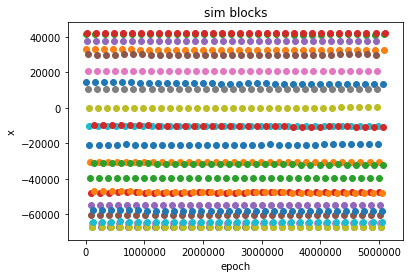

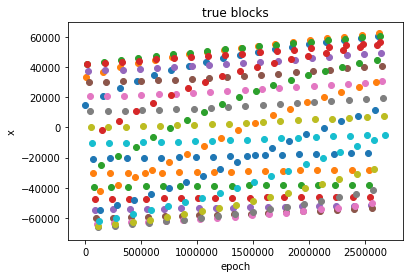

Sim T: 153835.02141911423, true T: 152897.41610171378


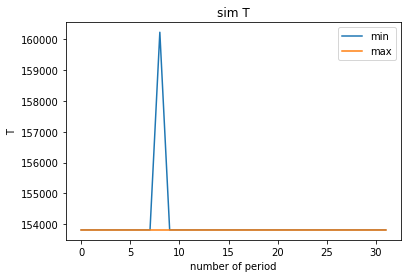

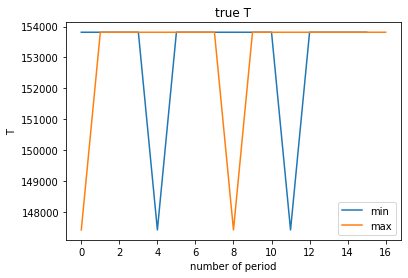

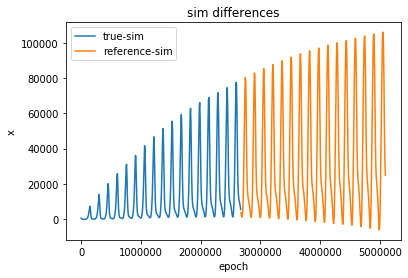

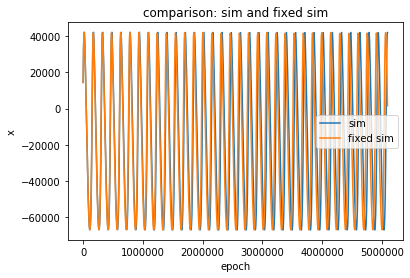

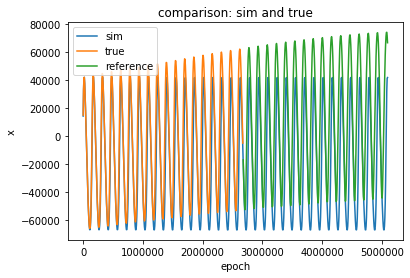

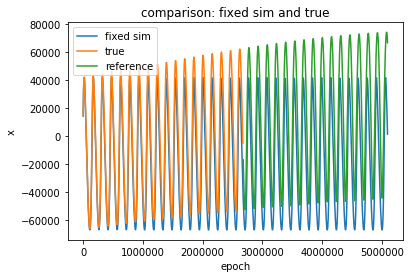

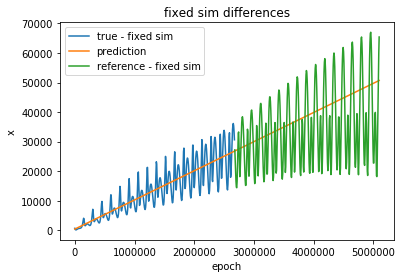

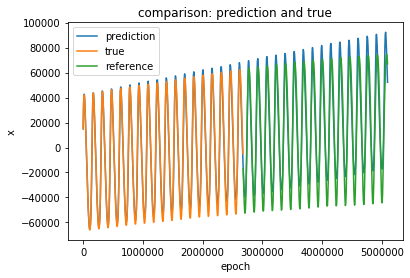

In [5]:
plot_one(train_data, test_data, reference, 6)

В данном случае заметны скачки по фазе: линии циклических блоков меняются местами в определенных местах. Впрочем, и для приближенного предсказания заметен дрейф циклических блоков. Видно, что даже в таком случае поправка средней частоты упрощает зависимость разности истинного и приближенного значения от времени. 

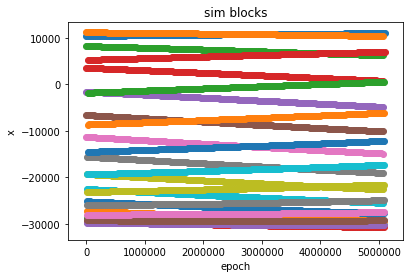

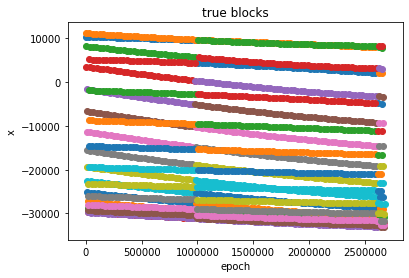

Sim T: 30492.978402561712, true T: 30510.874689087712


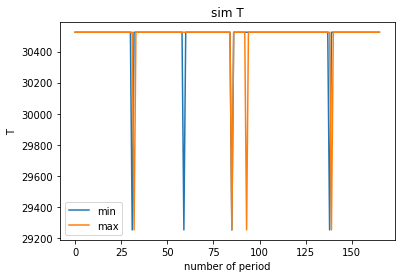

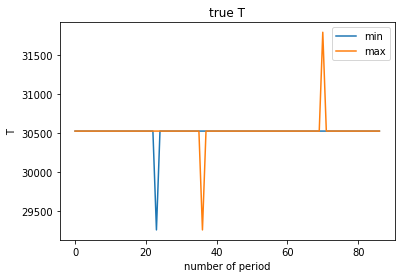

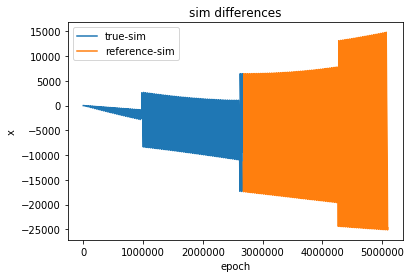

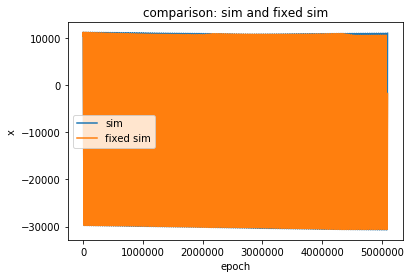

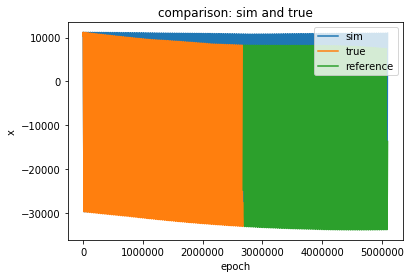

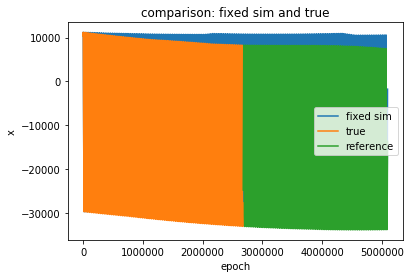

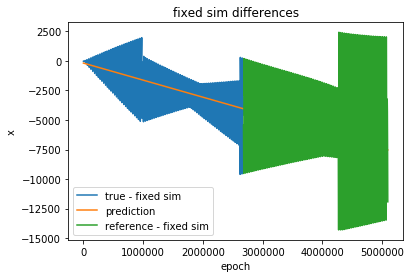

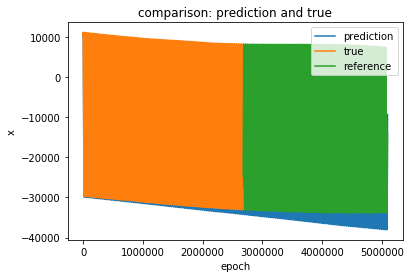

In [6]:
plot_one(train_data, test_data, reference, 1)

В данном случае видна модуляция после поправки на усредненную частоту, что означает более сложную зависимость частоты от времени, чем константа (модуляция может быть вызвана и скачками фазы). Возможно, успользование более точной подгонки частоты даст лучший эффект в данном случае, но даже используемый тривиальный подход дает существенное улучшение.

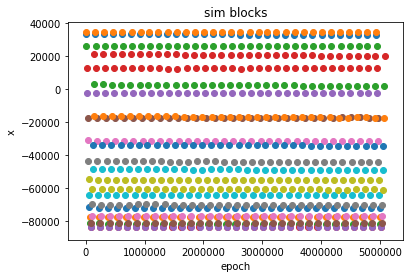

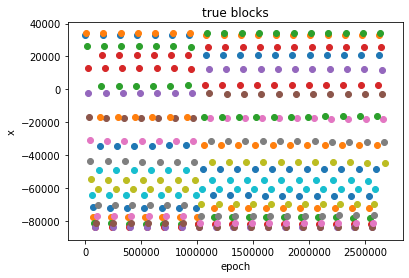

Sim T: 153928.3568304763, true T: 154550.4622248785


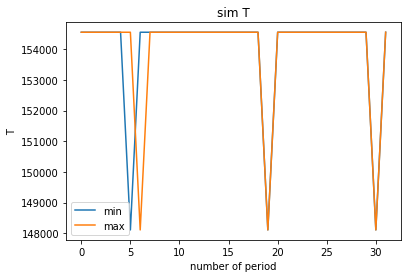

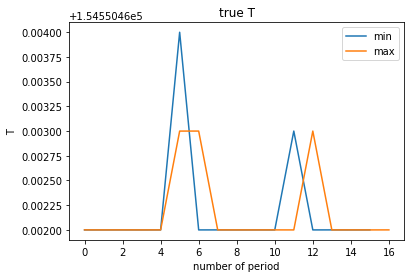

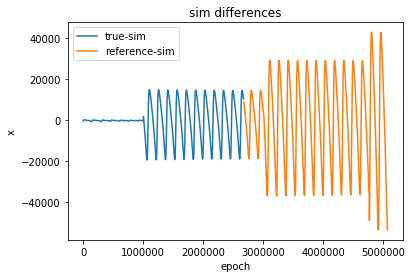

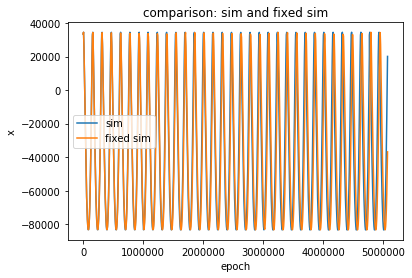

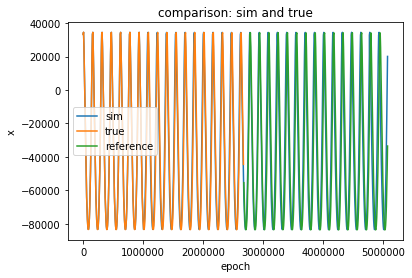

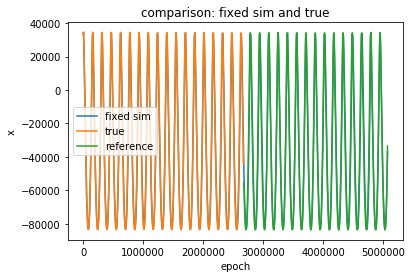

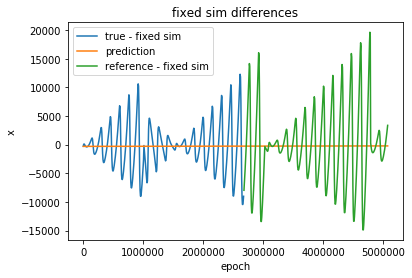

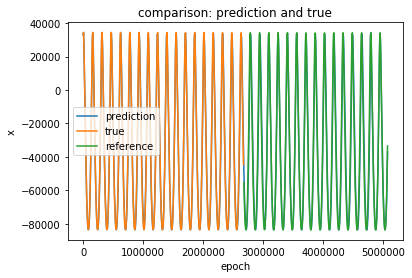

In [7]:
plot_one(train_data, test_data, reference, 2)

Еще один пример модуляций. Также в данном случае видны существенные выбросы частоты.

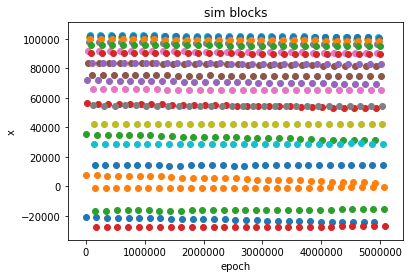

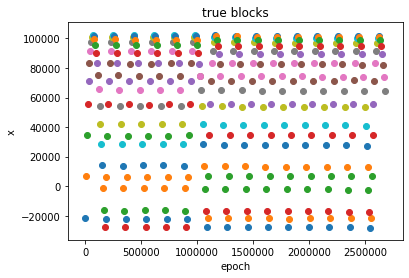

Sim T: 181288.29143328502, true T: 182090.08526190146


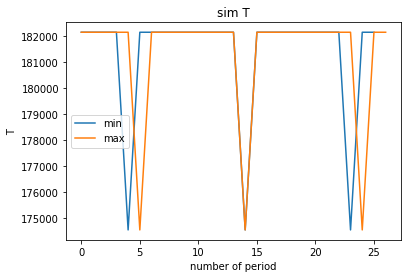

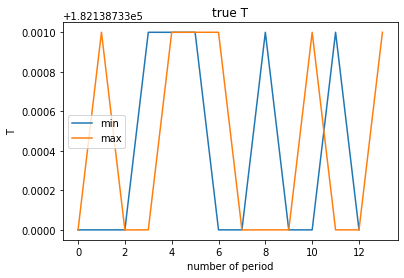

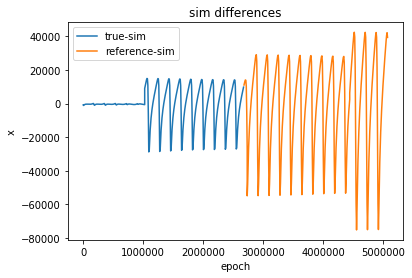

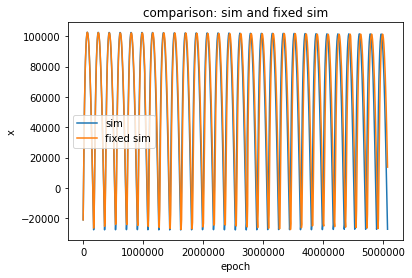

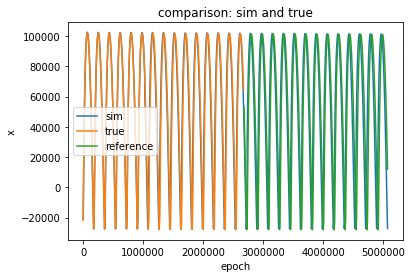

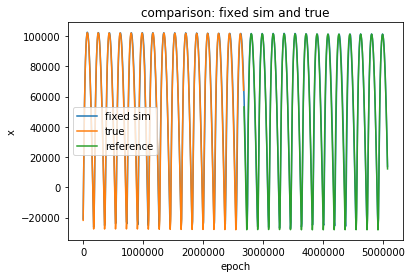

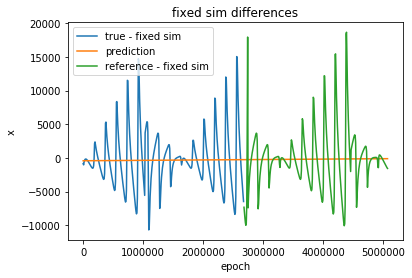

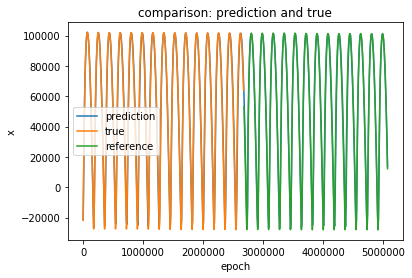

In [8]:
plot_one(train_data, test_data, reference, 3)

Получаем, что наибольший вклад в ошибку приближенной модели вносит фаза колебаний и даже простое исправление частоты дает существенное улучшение.